In [1]:
import os
import pandas as pd
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from matplotlib import font_manager, rc
fname = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = fname).get_name()
rc('font', family=font_name)

In [4]:
path = 'C:\\Users\\Msi\\Desktop\\data_analysis'
os.chdir(path)

In [5]:
data = pd.read_csv('auto-mpg.csv')
data = data.set_index('car name')
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


In [6]:
##### 데이터 전처리 과정 #####

In [7]:
# 결측치 확인
data.isnull().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
dtype: bool

In [8]:
### 데이터 type을 확인하기
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object

In [9]:
# horsepower column이 object로 표시되는 것으로 보아 확인이 필요하다.
# dataframe 안에 어떠한 원소들이 있는지 확인해보기 위해서는 unique를 사용한다.
data.horsepower.unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [10]:
# '?'가 섞여 있어 object type으로 표시되었기 때문에 '?'를 제거해주도록 한다.
# '?' 갯수 보기
list(data.horsepower).count('?')

6

In [11]:
data['horsepower'][data['horsepower'] == '?'] = None

In [12]:
# 제거 후 '?'의 갯수를 확인해보니 0개인 것을 볼 수 있다.
list(data.horsepower).count('?')

0

In [13]:
# KNNImputer 방법으로 결측치들을 채워주도록 한다.
imputer = KNNImputer(n_neighbors = 2, weights = 'distance')
df = pd.DataFrame(imputer.fit_transform(data))
df.columns = data.columns
df.index = data.index

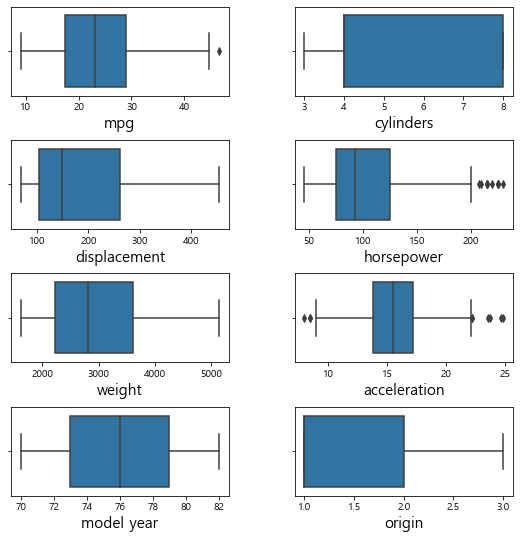

In [14]:
# boxplot을 활용하여 각 columns들의 데이터 형태를 확인해본다.
# boxplot에서는 이상치를 검출할 수 있다.
# horsepower에서의 몇몇 이상치가 보이지만 극단적인 이상치가 아니기 때문에
# 제거는 하지 않도록 한다.
plt.figure(figsize=(9, 9))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
for i in range(0, len(df.columns)):
    plt.subplot(4, 2, i+1)
    sns.boxplot(df.iloc[:,i])
    plt.xlabel(df.columns[i], fontsize = 15)
plt.show()

In [15]:
# index에 똑같은 차종이 있기 때문에 차종 뒤에 일련번호를 삽입한다.
df.index = df.index + df.groupby(level=0).cumcount().astype(str).replace('0','')

In [17]:
### boxplot을 이용한 이상치 제거
def boxplot_outlier(df):
    for i in range(np.shape(df)[1]):     
        Q1 = df.iloc[:,i-1].quantile(0.25)
        Q3 = df.iloc[:,i-1].quantile(0.75)
        IQR = Q3 - Q1
        outlier_left = float(Q1 - (2 * IQR))
        outlier_right = float(Q3 + (2 * IQR))
        outlier = df[(df.iloc[:,i-1] < outlier_left) | (df.iloc[:,i-1] > outlier_right)]
        df.iloc[:,i-1][outlier.index] = np.nan
    df_new = df.dropna()
    return df_new

df = boxplot_outlier(df)

In [18]:
# 데이터를 너무 많이 변형시켜놓으면 나중에 오류가 났을 때 바꾸기 힘들기 때문에
# 복사본을 하나 만들어 놓는 것이 좋다.
df_copy = df.copy()

In [16]:
##### EDA(탐색적 분석) #####
# 분석 목표 : 다른 요소들이 mpg(연비)값에 미치는 영향을 알아보자

In [19]:
# 전체 데이터 구조를 describe 함수로 훑어 본다.
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,23.472405,5.455696,193.279747,103.976168,2968.686076,15.537215,75.994937,1.572152
std,7.765956,1.699488,104.000382,37.875837,846.371022,2.673010,3.693179,0.804009
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.500000,75.000000,2224.500000,13.850000,73.000000,1.000000
50%,23.000000,4.000000,151.000000,93.000000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3607.000000,17.050000,79.000000,2.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,23.700000,82.000000,3.000000


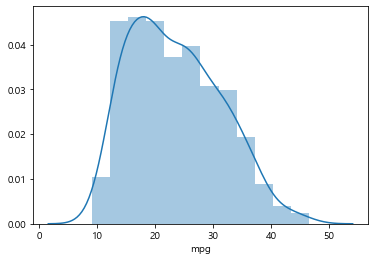

In [20]:
# mpg(연비)가 종속변수이기 때문에 그래프를 그려보고 확인해 본다.
# mpg(연비)는 살짝 왼쪽으로 치우친 정규분포 형태의 모양을 갖는다.
sns.distplot(df['mpg'])

In [21]:
# mpg의 첨도와 왜도를 확인해 본다.

# 첨도가 0보다 크면 그래프가 왼쪽으로 치우쳐져있다.
# 첨도가 0보다 작으면 그래프가 오른쪽으로 치우쳐져있다.
# 첨도가 0이면 어느 한쪽으로 치우쳐져 있지 않다.

# 왜도가 0보다 크면 정규분포 그래프보다 뾰족한 형태를 가진다.
# 왜도가 0보다 작으면 정규분포 그래프보다 완만한 형태를 가진다.
# 왜도가 0이면 정규분포의 형태를 가진다.

print("Skewness: %f" % df.mpg.skew())
print("Kurtosis: %f" % df.mpg.kurt())

Skewness: 0.441111
Kurtosis: -0.543338


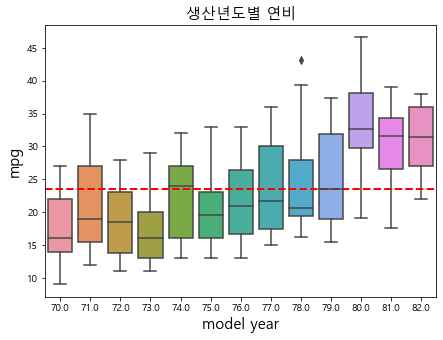

In [22]:
# 생산년도별 연비를 boxplot으로 확인해보자.
# 생산 연도가 늦어질 수록 즉, 시간이 지날 수록 
plt.subplots(figsize=(7, 5))
sns.boxplot(df['model year'], df['mpg'])
plt.axhline(df['mpg'].mean(), color = 'r',linestyle = '--', linewidth = 2)
plt.xlabel('model year', fontsize = 15)
plt.ylabel('mpg', fontsize = 15)
plt.title('생산년도별 연비', fontsize = 15)
plt.show()

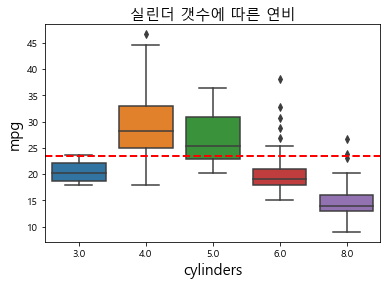

In [23]:
# 실린더 갯수에 따른 연비 확인
plt.plot(figsize=(8, 6))
sns.boxplot(df['cylinders'], df['mpg'])
plt.axhline(df['mpg'].mean(), linestyle = '--', color = 'r', linewidth = 2)
plt.xlabel('cylinders', fontsize = 15)
plt.ylabel('mpg', fontsize = 15)
plt.title('실린더 갯수에 따른 연비', fontsize = 15)
plt.show()

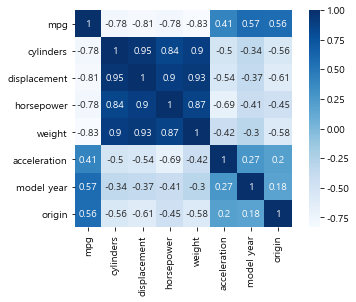

In [24]:
# 히트맵을 이용하여 각 변수의 관계를 상관계수로 알아본다.
# cylinders, displacement, weight 이 세 변수 간 상관관계가 높아 다중공선성이 의심되므로 제거가 필요하다.
mpg_corr = df.corr()
plt.plot(figsize=(7, 5))
sns.heatmap(mpg_corr, cmap = 'Blues', annot = True, square = True)
plt.show()

In [25]:
# 연비가 가장 높은 차 구하기
# 연비가 가장 높은 차는 일본의 mazda glc이다.
df[df['mpg'] == max(df['mpg'])]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
mazda glc,46.6,4.0,86.0,65.0,2110.0,17.9,80.0,3.0


In [26]:
# 연비가 가장 낮은 차 구하기
# 연비가 가장 낮은 차는 미국의 hi 1200d이다.
df[df['mpg'] == min(df['mpg'])]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
hi 1200d,9.0,8.0,304.0,193.0,4732.0,18.5,70.0,1.0


In [27]:
# country_code에 1, 2, 3으로 되어있는 데이터를 미국, 유럽, 일본으로 바꿔준다.
df['country'] = df['origin'].replace([1, 2, 3], ['USA', 'Europe','Japan'])
df['country']

chevrolet chevelle malibu    USA
buick skylark 320            USA
plymouth satellite           USA
amc rebel sst                USA
ford torino                  USA
                            ... 
chevrolet camaro             USA
ford mustang gl              USA
dodge rampage                USA
ford ranger                  USA
chevy s-10                   USA
Name: country, Length: 395, dtype: object

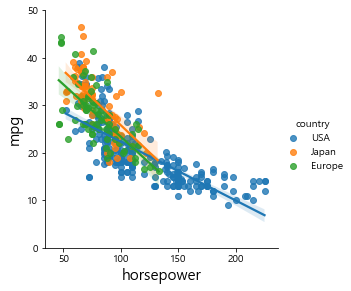

In [28]:
# 마력과 연비간의 회귀선을 국가별로 나눠서 볼 수 있다.
sns.lmplot('horsepower', 'mpg', data=df, hue='country', size = 4)
plt.ylim(0, 50)
plt.xlabel('horsepower', fontsize = 15)
plt.ylabel('mpg', fontsize = 15)
plt.show()

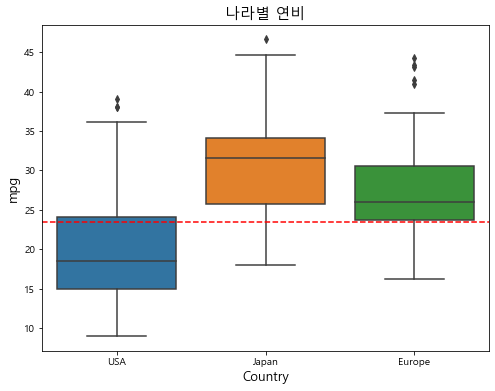

In [29]:
# 나라별 연비를 한번 boxplot으로 확인해보도록 하자.
plt.figure(figsize=(8, 6))
sns.boxplot(df['country'], df['mpg'])
plt.axhline(df['mpg'].mean(), linestyle='--', color='r')
plt.xlabel("Country", fontsize = 13)
plt.ylabel('mpg', fontsize = 13)
plt.title('나라별 연비', fontsize = 15)
plt.show()

In [28]:
##### 데이터 분석 #####

In [30]:
dummy = pd.get_dummies(df['origin'])
dummy.columns = ['USA', 'Europe', 'Japan']
df_new = pd.concat([df, dummy], axis = 1)
df_new = df_new.drop(['origin', 'country'], axis = 1)
df_new

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,Japan
chevrolet chevelle malibu,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1,0,0
buick skylark 320,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1,0,0
plymouth satellite,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1,0,0
amc rebel sst,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1,0,0
ford torino,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
chevrolet camaro,27.0,4.0,151.0,90.0,2950.0,17.3,82.0,1,0,0
ford mustang gl,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1,0,0
dodge rampage,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1,0,0
ford ranger,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1,0,0


In [31]:
# 데이터들의 범위가 다르기 때문에 overfitting과 underfitting을 방지하기 위해 scaling을 해준다.
# 여러가지 scale 기법이 있지만 더미변수의 변화를 유지하기 위해 MinMaxScaler를 사용하도록 한다.
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_new)
scaled = pd.DataFrame(scaled)
scaled.columns = df_new.columns
scaled.index = df_new.index
scaled

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,Japan
chevrolet chevelle malibu,0.239362,1.0,0.617571,0.469274,0.536150,0.254777,0.0,1.0,0.0,0.0
buick skylark 320,0.159574,1.0,0.728682,0.664804,0.589736,0.222930,0.0,1.0,0.0,0.0
plymouth satellite,0.239362,1.0,0.645995,0.581006,0.516870,0.191083,0.0,1.0,0.0,0.0
amc rebel sst,0.186170,1.0,0.609819,0.581006,0.516019,0.254777,0.0,1.0,0.0,0.0
ford torino,0.212766,1.0,0.604651,0.525140,0.520556,0.159236,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
chevrolet camaro,0.478723,0.2,0.214470,0.245810,0.379076,0.592357,1.0,1.0,0.0,0.0
ford mustang gl,0.478723,0.2,0.186047,0.223464,0.333711,0.484076,1.0,1.0,0.0,0.0
dodge rampage,0.611702,0.2,0.173127,0.212291,0.193365,0.229299,1.0,1.0,0.0,0.0
ford ranger,0.505319,0.2,0.134367,0.184358,0.286929,0.675159,1.0,1.0,0.0,0.0


In [31]:
# 위에서 히트맵을 확인해본 결과 다중공선성이 의심되었기 때문에 correlation을 확인해보고
# 상관관계가 높은 변수들은 제거해 주도록 한다.
# cylinders, displacement, weight 세가지 변수 간의 상관관계가 약 90% 이상이기 때문에 하나만 남겨두고
# 모두 제거하도록 한다.
corr = scaled.corr()
corr

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,Japan
mpg,1.000000,-0.775396,-0.804203,-0.778379,-0.831741,0.420289,0.579267,-0.568192,0.259022,0.442174
cylinders,-0.775396,1.000000,0.950721,0.843057,0.896017,-0.505419,-0.348746,0.604351,-0.352861,-0.396479
displacement,-0.804203,0.950721,1.000000,0.897806,0.932824,-0.543684,-0.370164,0.651407,-0.373886,-0.433505
horsepower,-0.778379,0.843057,0.897806,1.000000,0.865264,-0.688429,-0.415046,0.487610,-0.290117,-0.314721
weight,-0.831741,0.896017,0.932824,0.865264,1.000000,-0.417457,-0.306564,0.598398,-0.298843,-0.440817
acceleration,0.420289,-0.505419,-0.543684,-0.688429,-0.417457,1.000000,0.288137,-0.250806,0.204473,0.109144
model year,0.579267,-0.348746,-0.370164,-0.415046,-0.306564,0.288137,1.000000,-0.139883,-0.024489,0.193101
USA,-0.568192,0.604351,0.651407,0.487610,0.598398,-0.250806,-0.139883,1.000000,-0.597198,-0.643317
Europe,0.259022,-0.352861,-0.373886,-0.290117,-0.298843,0.204473,-0.024489,-0.597198,1.000000,-0.229895
Japan,0.442174,-0.396479,-0.433505,-0.314721,-0.440817,0.109144,0.193101,-0.643317,-0.229895,1.000000


In [37]:
# 조금 더 정확하게 다중공선성을 확인해 보기 위해 vif(분산팽창지수)를 이용한다.
# vif가 10 이상이면 다중공선성을 의심해봐야한다.
# 밑의 결과를 보았을 때 가장큰 값을 가지는 vif 부터 제거해주도록한다.
a = scaled.drop(['mpg', 'USA', 'Europe', 'Japan'], axis = 1)
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
vif.index = a.columns
vif

,VIF Factor
cylinders,31.694422
displacement,47.766102
horsepower,15.901536
weight,34.366641
acceleration,5.522307
model year,3.710362


In [38]:
# displacement 변수를 제거해 준 뒤에 vif를 확인해본 결과 아직 다중공선성이 의심되는
# 변수들이 확인되었기 때문에 그 다음으로 vif가 높은 weight를 제거해준다.
a = a.drop(['displacement'], axis = 1)
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
vif.index = a.columns
vif

,VIF Factor
cylinders,17.445645
horsepower,14.989250
weight,25.740710
acceleration,4.686282
model year,3.653360


In [39]:
# weight 변수를 제거해 준 뒤에 확인해보니 어느 정도 vif가 약 10정도 되는 것을
# 확인할 수 있다. 어느 정도 다중공선성의 문제가 해결됬다고 생각되어 다음 분석을
# 진행하도록 하겠다.
a = a.drop(['weight'], axis = 1)
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
vif.index = a.columns
vif

,VIF Factor
cylinders,11.013003
horsepower,10.630152
acceleration,4.337587
model year,3.652840


In [41]:
# cylinders, displacement, weight 간의 상관관계가 높아
# 다중공선성 문제가 발생하기 때문에 몇개의 변수를 제거해주고 분석을 진행한다.
# 아래와 같이 statsmodel.api를 통해 회귀분석을 할 수 있지만 이럴 경우에는
# train set과 test set을 나누어 분석할 수 없기 때문에 추천하는 방법은 아니다.
# 다만 전체적으로 빠르게 통계량을 확인하고 싶을 때 좋은 방법이다.

y = scaled['mpg']
x = scaled.drop(['mpg', 'displacement', 'weight'], axis = 1)
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     228.5
Date:                Tue, 09 Jun 2020   Prob (F-statistic):          5.18e-124
Time:                        21:47:28   Log-Likelihood:                 361.56
No. Observations:                 395   AIC:                            -709.1
Df Residuals:                     388   BIC:                            -681.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4660      0.023     20.031      0.000       0.420       0.512
cylinders       -0.1437      0.030     -4.793      0.000      -0.203      -0.085
horsepower      -0.4648      0.054     -8.636      0.000      -0.571      -0.359
acceleration    -0.2012      0.041     -4.928      0.000      -0.281      -0.121
model year       0.2085      0.018     11.692      0.000       0.173       0.244
USA              0.1023      0.012      8.233      0.000       0.078       0.127
Europe           0.1644      0.012     13.905      0.000       0.141       0.188
Japan            0.1993      0.011     17.397      0.000       0.177       0.222
==============================================================================
Omnibus:                       34.178   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.089
Skew:                           0.577   Prob(JB):                     1.80e-12
Kurtosis:                       4.398   Cond. No.                     1.06e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.23e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
# train set과 test set을 8:2 비율로 나눈다.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=37)

In [43]:
# sklearn의 LinearRegression 모델로 학습시켜 결과를 확인한다.
# 여기서는 r_square 값을 lr.score로 나타낼 수 있는데 train set으로 학습 시킨
# 모델에 대하여 test set을 가지고 r_square값을 구해야 한다.
# 그리고 실제값과 예측값의 오차(mse)가 0에 가까울 수록 좋은 모델에 가까워진다.
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
r_square = lr.score(x_test, y_test)
mse = mean_squared_error(y_test, y_pred)
mse

0.0097006341239731

In [54]:
# ridge 회귀
ridge = Ridge(random_state=37, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = dict(alpha=alphas)

clf_ridge = GridSearchCV(ridge, tuned_parameters, cv=5, scoring='neg_mean_squared_error', refit=True)
clf_ridge.fit(x_train, y_train)
scores = clf_ridge.cv_results_['mean_test_score']
scores_std = clf_ridge.cv_results_['std_test_score']

ridge = clf_ridge.best_estimator_
ridge

y_pred_ridge = clf_ridge.predict(x_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge

0.009509321041402596

In [55]:
# lasso 회귀
lasso = Lasso(random_state=37, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = dict(alpha=alphas)

clf_lasso = GridSearchCV(lasso, tuned_parameters, cv=5, scoring='neg_mean_squared_error', refit=True)
clf_lasso.fit(x_train, y_train)
scores = clf_lasso.cv_results_['mean_test_score']
scores_std = clf_lasso.cv_results_['std_test_score']

lasso = clf_lasso.best_estimator_
lasso

y_pred_lasso = clf_lasso.predict(x_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_lasso

0.009580105113089724

In [56]:
# elasticnet 회귀
parameters = dict(alpha=alphas,l1_ratio=np.arange(0.0,1,0.05))
eNet = ElasticNet(random_state=42, max_iter=10000)
clf_eNet = GridSearchCV(eNet,tuned_parameters,cv=5,scoring="neg_mean_squared_error", refit=True)
clf_eNet.fit(x_train,y_train)

eNet = clf_eNet.best_estimator_
eNet

y_pred_eNet = clf_eNet.predict(x_test)
mse_eNet = mean_squared_error(y_test,y_pred_eNet)
mse_eNet

0.00954270829278018

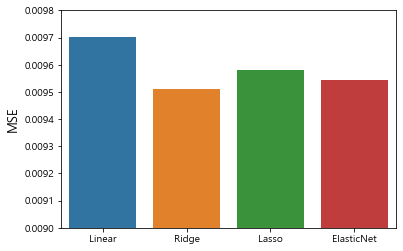

In [57]:
# 4가지 방법으로 mse를 비교해 봤을 때 Ridge 회귀의 mse가 가장 작아
# 이 데이터에 맞는 가장 좋은 모델이라 볼 수 있다.
model_name = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']
mse_score = [mse, mse_ridge, mse_lasso, mse_eNet]

sns.barplot(model_name, mse_score)
plt.ylim(0.009, 0.0098)
plt.ylabel('MSE', fontsize=13)
plt.show()

In [60]:
# 최종 회귀식
print("coef : ", clf_ridge.best_estimator_.coef_)
print("intercept : ", clf_ridge.best_estimator_.intercept_)

coef :  [ 0.         -0.14134935 -0.51073035 -0.19057076  0.18545497 -0.04843363
  0.00859344  0.0398402 ]
intercept :  0.6489350952151633
